# University of Nicosia
# COMP-548DL
## Big Data Management and Processing
## Semester Project
## Project Title: E-commerce Customer Behavior Analysis
## Maria Chrysanthou

COMP-548DL course will focus on Big Data Management and Processing where  we will use analyze from E-commerce Customer Behavior. With more and more people shopping online, it's become super important for businesses to get a grip on what their customers are up to. In this project, we're going to play detective with an e-commerce dataset, uncovering who's buying what, spotting trends, and getting some cool insights on customer behavior.

The E-commerce Dataset has been taken from Kaggle. The dataset in a global scale shows who's buying, what they're buying, and how they're buying it.

The specific dataset has been used due to its Big Data Challenges:  Volume, Variety, and Velocity.

Setup Enviroment Variable

In [1]:
 %env GOOGLE_APPLICATION_CREDENTIALS=C:\Users\maria\Downloads\comp548-m-chrysanthou-e7d5f3bef30f.json

env: GOOGLE_APPLICATION_CREDENTIALS=C:\Users\maria\Downloads\comp548-m-chrysanthou-e7d5f3bef30f.json


In [2]:
import sys
!{sys.executable} -m pip install --upgrade google-cloud-firestore

### Load Dataset

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the data into a Pandas DataFrame to inspect it
data_df = pd.read_csv('data.csv')

# Display the first few rows 
data_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Upload the dataset to Firestore

Hereby, we handle large-scale data ingestion into Firestore by splitting the process into manageable batches. This is to avoid limits on write operations and ensuring efficient data transfer.

In [4]:
from google.cloud import firestore

# establish a connection with db
db = firestore.Client()

# Function to convert a row to a Firestore document
def row_to_document(row):
    # Convert NaN to None for Firestore compatibility
    return row.where(pd.notnull(row), None).to_dict()

# Batch Ingestion
## Firestore has limits on the number of writes we can do in a single operation.
## We use batch processing, to handle the above.
batch = db.batch()
collection_name = 'sales_data'
for index, row in data_df.iterrows():
    doc_ref = db.collection(collection_name).document()  # Auto-generate document ID
    batch.set(doc_ref, row_to_document(row))

    # Commit in batches of 500 to avoid exceeding limits
    if (index + 1) % 500 == 0:
        batch.commit()
        batch = db.batch()

### Data Cleaning and Preprocessing
In this step, we identify missing values in the dataset and make decisions on how we handle these values.

In [5]:
# Identifying missing values in the dataset
missing_values = data_df.isnull().sum()

# Percentage of missing values for each column
missing_percentage = (missing_values / len(data_df)) * 100

# Overview of the missing data in our dataset
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_summary

,Missing Values,Percentage
InvoiceNo,0,0.000000
StockCode,0,0.000000
Description,1454,0.268311
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
CustomerID,135080,24.926694
Country,0,0.000000


In [6]:
# Handling missing values

# Removing records with missing 'Description'
data_cleaned = data_df.dropna(subset=['Description'])

# Replacing missing 'CustomerID' values with a placeholder (-1)
data_cleaned['CustomerID'].fillna(-1, inplace=True)

# Check the dataset after handling missing values
missing_values_after = data_cleaned.isnull().sum()
missing_summary_after = pd.DataFrame({'Missing Values After Cleaning': missing_values_after})
missing_summary_after

C:\Users\maria\anaconda3\COMP542DL\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Missing Values After Cleaning
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


### Perform label encoding on categorical columns in a Dataframe

Here, we preprocess categorical data and represent them with numeric values. The reason for this procedure is to make data suitable for use in algorithms, which require numerical input.

In [7]:
from sklearn.preprocessing import LabelEncoder

# Creating a copy of the data for encoding
data_encoded = data_cleaned.copy()

# Initializing LabelEncoder
# This encoder assigns a unique integer to each unique category within a column.
label_encoder = LabelEncoder()

# List of columns to be label encoded
categorical_columns = ['InvoiceNo', 'StockCode', 'Description', 'Country']

# Applying label encoding to each categorical column
for column in categorical_columns:
    data_encoded[column] = label_encoder.fit_transform(data_encoded[column])

# Display the first few rows of the encoded DataFrame
data_encoded.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,3438,3918,6,12/1/2010 8:26,2.55,17850.0,36
1,0,2739,3926,6,12/1/2010 8:26,3.39,17850.0,36
2,0,2975,913,8,12/1/2010 8:26,2.75,17850.0,36
3,0,2919,1910,6,12/1/2010 8:26,3.39,17850.0,36
4,0,2918,2911,6,12/1/2010 8:26,3.39,17850.0,36


We transform DataFrame into a format that can be uploaded to Firestore.

In [8]:
# Data Preparation for Firestore
# Converting DataFrame to a list of dictionaries
# This format is suitable for uploading to Firestore
data_for_firestore = data_encoded.to_dict(orient='records')

# Display the first record to verify the format
data_for_firestore[0] if len(data_for_firestore) > 0 else "No data available"

{'InvoiceNo': 0,
 'StockCode': 3438,
 'Description': 3918,
 'Quantity': 6,
 'InvoiceDate': '12/1/2010 8:26',
 'UnitPrice': 2.55,
 'CustomerID': 17850.0,
 'Country': 36}

### Upload data to a Firestore collection in batches

We upload our data to the Firestore collection, using batches for efficient processing.

In [9]:
from google.cloud import firestore

# Initialize Firestore client
db = firestore.Client()

# Function to upload data to Firestore in batches
def upload_to_firestore(data, collection_name, batch_size=500):
    batch = db.batch()
    collection_ref = db.collection(collection_name)

    for i, record in enumerate(data):
        doc_ref = collection_ref.document()  # Auto-generate document ID
        batch.set(doc_ref, record)

        # Commit in batches of specified size to avoid exceeding limits
        if (i + 1) % batch_size == 0:
            batch.commit()
            batch = db.batch()

    # Commit any remaining documents
    batch.commit()

# Call the function to start the upload process
collection_name = 'sales_data'  # Replace with your collection name
upload_to_firestore(data_for_firestore, collection_name)

### Customer Segmentation

We begin the process by retrieving sales data from Firestore collection, aggregating it by customer, and then converting the aggregated data into pandas DataFrame.

In [10]:
## Firestore Query for Customer Segmentation

# Query to retrieve sales data grouped by CustomerID
# Retrieve up to 100 documents from the collection
# Limit the number of documents to prevenet loading huge amount of data
sales_data = db.collection('sales_data').limit(100).stream()

# Process the data in Python
customer_data = {}
for doc in sales_data:
    record = doc.to_dict() # convert Firestore doc to Python dictionary
    customer_id = record['CustomerID']

    # Aggregate data for each customer
    if customer_id not in customer_data:
        customer_data[customer_id] = {
            'total_spend': 0,
            'total_transactions': 0,
        }
    
    customer_data[customer_id]['total_spend'] += record['UnitPrice'] * record['Quantity']
    customer_data[customer_id]['total_transactions'] += 1

# Now customer_data contains aggregated data for each customer

# Convert the customer_data to a DataFrame
import pandas as pd
customer_df = pd.DataFrame.from_dict(customer_data, orient='index')

We preprocess the data for clustering analysis. We normalize the feature values in dataset, in order to be on comparable scale.

In [11]:
## Prepocess the Data for Clustering

from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_df)

For clustering analysis, we use K-means which adopt distance measurements to determine the similarity between data points. We standardize features to prevent influence on the model from features, which are on larger scales.

In [12]:
## Apply Clustering Algorithm

from sklearn.cluster import KMeans

# Choose the number of clusters (k)
k = 3 
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster information back to the DataFrame
customer_df['Cluster'] = clusters


C:\Users\maria\anaconda3\COMP542DL\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\maria\anaconda3\COMP542DL\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [13]:
## Analyze the Customer Segments

# Analyze the mean values of each cluster
cluster_analysis = customer_df.groupby('Cluster').mean()

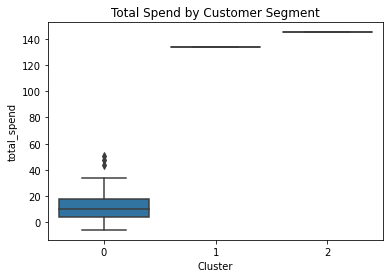

In [14]:
## Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting total spend by cluster
sns.boxplot(x='Cluster', y='total_spend', data=customer_df)
plt.title('Total Spend by Customer Segment')
plt.show()

Diving into the box plot, we uncover how different customer segments are spending their money. We've got three segments here – 0, 1, and 2. 
+ **Budget Shoppers (Cluster 0)**: This Cluster's median spend is the lowest, and they keep their purchases tight and consistent. 
+ **Casual Spenders (Cluster 1)**: Spenders in Clurster 1 are the customers who show more flexibility in their spending. 
+ **Enigmatic Expenders (Cluster 2)**: Cluster 2 spending pattern isn’t as clear-cut from the plot. 

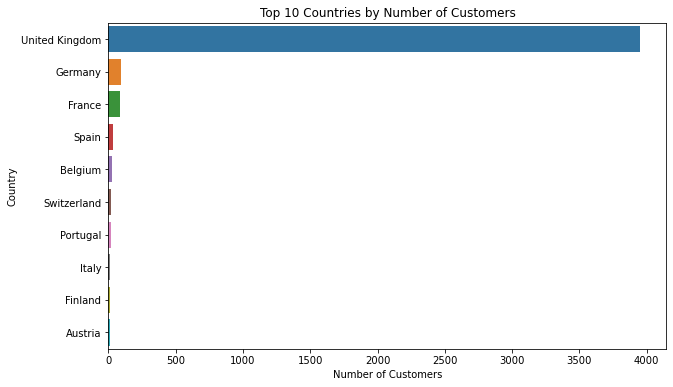

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Counting the number of unique customers in each country
country_customer_counts = data_df.groupby('Country')['CustomerID'].nunique()

# Sorting and selecting the top 10 countries
top_10_countries = country_customer_counts.sort_values(ascending=False).head(10)

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_countries.values, y=top_10_countries.index)
plt.title('Top 10 Countries by Number of Customers')
plt.xlabel('Number of Customers')
plt.ylabel('Country')
plt.show()

The insights from these plot are:
+ **Dominant UK Market**: The United Kingdom is the dominant market in terms of the customer base.
+ **European Customer Base**: Other countries in the list are primarily European, which suggests that the business has a significant presence or focus in Europe.
+ **Market Penetration Opportunities**: The noticeable drop in customer numbers from the UK to Germany and others could indicate potential for market penetration or expansion in these other countries. 

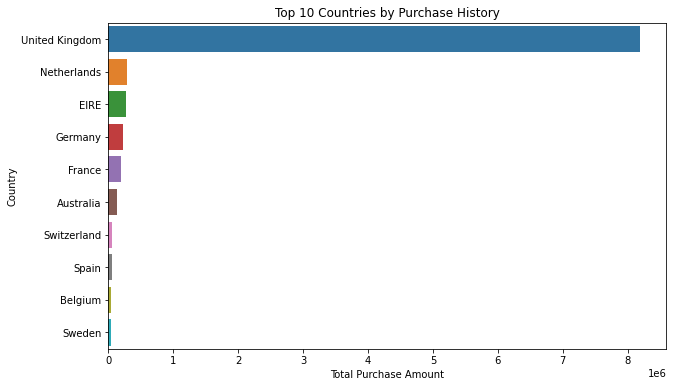

In [16]:
df = pd.read_csv('data.csv')

# Calculating total purchase amount for each country
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
country_purchase = df.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False).head(10)

# Visualization of top 10 countries based on purchase history
plt.figure(figsize=(10, 6))
sns.barplot(x=country_purchase.values, y=country_purchase.index)
plt.title('Top 10 Countries by Purchase History')
plt.xlabel('Total Purchase Amount')
plt.ylabel('Country')
plt.show()

This chart can provide strategic insights for business growth, marketing, and customer engagement:

+ **Market Dominance of the UK** : The United Kingdom stands out with a significantly higher total purchase amount compared to other countries, indicating that it is the primary market for the business. The UK's dominance in sales could be due to a larger customer base, higher spending per customer, or a combination of both.
+ **Secondary Markets**: The Netherlands and EIRE (Ireland) follow as the next two countries, suggesting that these regions are important secondary markets for the company. 
+ **Market Expansion Potential**: The presence of countries like Australia and Sweden in the list, despite their geographical distance from the UK, suggests that the business has international appeal. 

### Browsing behavior

The data do not contain explicit data on browsing behavior. In the absence of direct browsing behavior data,we will use the available data to infer browsing behavior. For instance, we could assume that a higher number of unique products purchased or a higher frequency of purchases may indicate more active browsing behavior.

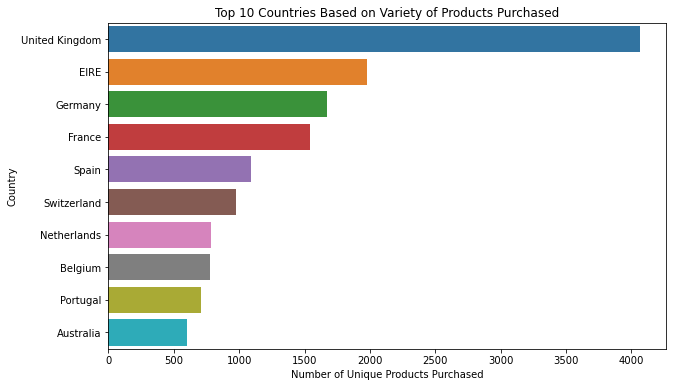

In [17]:
# Inferring browsing behavior based on the number of unique products purchased per country
# This assumes that a higher variety of products purchased might indicate more active browsing behavior

# Counting the number of unique products (StockCode) purchased in each country
browsing_behavior = df.groupby('Country')['StockCode'].nunique().sort_values(ascending=False).head(10)

# Visualization of top 10 countries based on inferred browsing behavior
plt.figure(figsize=(10, 6))
sns.barplot(x=browsing_behavior.values, y=browsing_behavior.index)
plt.title('Top 10 Countries Based on Variety of Products Purchased')
plt.xlabel('Number of Unique Products Purchased')
plt.ylabel('Country')
plt.show()


This bar chart illustrates the number of unique products purchased in each country.
The United Kingdom is leading by a significant margin, indicating that consumers there have purchased the most diverse range of products among the countries listed. EIRE (Ireland) follows as the second, with Germany, France, and Spain rounding out the top five.

### Exploration of trends over time and seasonal variatons

In [18]:
# Data Cleaning and Transformation

# Checking for missing values
missing_values = data_df.isnull().sum()

# Data type conversion for 'InvoiceDate'
# Convert 'InvoiceDate' column to datetime format
data_df['InvoiceDate'] = pd.to_datetime(data_df['InvoiceDate'])

# Adding features like Year, Month, Day of Week
data_df['Year'] = data_df['InvoiceDate'].dt.year
data_df['Month'] = data_df['InvoiceDate'].dt.month
data_df['DayOfWeek'] = data_df['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6

# Normalization: Not immediately necessary as we are not performing ML tasks right now

# Displaying the updated DataFrame and missing values information
updated_head = data_df.head()
missing_values, updated_head

(InvoiceNo           0
 StockCode           0
 Description      1454
 Quantity            0
 InvoiceDate         0
 UnitPrice           0
 CustomerID     135080
 Country             0
 dtype: int64,
   InvoiceNo StockCode                          Description  Quantity  \
 0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1    536365     71053                  WHITE METAL LANTERN         6   
 2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
           InvoiceDate  UnitPrice  CustomerID         Country  Year  Month  \
 0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  2010     12   
 1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  2010     12   
 2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  2010     12   
 3 2010-12-01 08:26:00       3.39     17850.0  Un

### Upload data from a pandas DataFrame to Firestore

In [19]:
def upload_data_to_firestore(df, batch_size=500):
    batch = db.batch()
    count = 0
    for index, row in df.iterrows():
        doc_ref = db.collection('Sales').document(row['InvoiceNo'])
        batch.set(doc_ref, row.to_dict())
        count += 1
        if count % batch_size == 0:
            batch.commit()
            batch = db.batch()
    if count % batch_size != 0:
        batch.commit()

In [20]:
# Execute the upload
upload_data_to_firestore(data_df)

Data analysis on Firestore dataset to count sales transactions per month and calculate average transaction value over time.

In [21]:
# Count Sales Transactions Per Month
# Retrieve document from Firestore collection
def fetch_data(collection_name):
    documents = db.collection(collection_name).stream()
    return [doc.to_dict() for doc in documents]

# Fetch sales data
sales_data = fetch_data('Sales')

# Convert to DataFrame
df = pd.DataFrame(sales_data)

# Aggregate sales per month in Pandas
monthly_sales_count = df.groupby('Month').size()

# Print the monthly sales count
print(monthly_sales_count)


# Average Transaction Value Over Time
# Fetch all sales transactions
sales_transactions = db.collection('Sales').get()

# Calculate the average transaction value
total_value = 0
count = 0
for transaction in sales_transactions:
    total_value += transaction.to_dict()['UnitPrice'] * transaction.to_dict()['Quantity']
    count += 1
average_transaction_value = total_value / count if count > 0 else 0
print(f"Average Transaction Value: {average_transaction_value}")


Month
1     1476
2     1393
3     1983
4     1744
5     2162
6     2012
7     1927
8     1737
9     2327
10    2637
11    3462
12    3040
dtype: int64
Average Transaction Value: 26.366807413128097


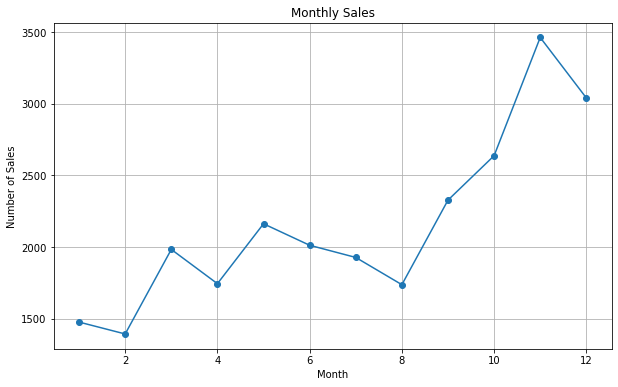

In [22]:
# Fetch sales data
sales_transactions = db.collection('Sales').get()

# Prepare data for visualization
monthly_sales = {}
for transaction in sales_transactions:
    month = transaction.to_dict()['Month']
    monthly_sales[month] = monthly_sales.get(month, 0) + 1

# Convert to DataFrame
df = pd.DataFrame(list(monthly_sales.items()), columns=['Month', 'Sales'])

# Sort by month
df = df.sort_values(by='Month')

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['Sales'], marker='o')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.grid(True)
plt.show()

Each month reveals a distinct pattern in shopping habits and the rhythm of the retail world where the consumer spends. 

+ **January & February**: Sales start modestly, with a small dip following the initial month, suggesting post-holiday spending fatigue.

+ **Spring Recovery**: Sales begin to rise steadily from March through May, indicating a seasonal upturn as consumer activity increases.

+ **Summer Fluctuation**: A slight decrease in June, possibly due to a seasonal adjustment period, is followed by a rebound in July and August. 

+ **Autumn Dip**: September sees a decrease in sales, which may be related to consumers saving in anticipation of holiday spending.

+ **Year-End Surge**: A significant rise from October, with a peak in December, likely reflects the impact of holiday sales, including Black Friday and Christmas shopping, suggesting the highest consumer spending period.

On the question "Analyze patterns in purchasing behaviour" I faced technical limitations with Firestore's querying skills. The complexity of the queries required for my analysis exceeded the scope of Firestore's use, leading me to performance issues.